In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil

# Set paths
csv_path = '/content/drive/MyDrive/labels.csv'
img_dir = '/content/drive/MyDrive/DeepWeed/images'
base_dir = '/content/DeepWeed_split'  # new split location in Colab

# Create folders
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(base_dir, split), exist_ok=True)

# Read CSV
df = pd.read_csv(csv_path)


In [7]:
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['Species'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Species'], random_state=42)

def copy_images(dataframe, split):
    for _, row in dataframe.iterrows():
        label = row['Species']
        fname = row['Filename']
        src = os.path.join(img_dir, fname)
        dst_dir = os.path.join(base_dir, split, label)
        os.makedirs(dst_dir, exist_ok=True)
        if os.path.exists(src):
            shutil.copy(src, os.path.join(dst_dir, fname))

copy_images(train_df, 'train')
copy_images(val_df, 'val')
copy_images(test_df, 'test')

print("✅ Dataset split completed.")


✅ Dataset split completed.


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    os.path.join(base_dir, 'train'), target_size=img_size,
    batch_size=batch_size, class_mode='categorical'
)

val_data = val_gen.flow_from_directory(
    os.path.join(base_dir, 'val'), target_size=img_size,
    batch_size=batch_size, class_mode='categorical'
)

test_data = test_gen.flow_from_directory(
    os.path.join(base_dir, 'test'), target_size=img_size,
    batch_size=1, shuffle=False, class_mode='categorical'
)

num_classes = train_data.num_classes


Found 0 images belonging to 9 classes.
Found 0 images belonging to 9 classes.
Found 0 images belonging to 9 classes.


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

# Define image generators
train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

# Point to the correct directory
train_data = train_gen.flow_from_directory(
    directory=os.path.join(base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_data = val_gen.flow_from_directory(
    directory=os.path.join(base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_data = test_gen.flow_from_directory(
    directory=os.path.join(base_dir, 'test'),
    target_size=img_size,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# Confirm class count
num_classes = train_data.num_classes
print("Classes found:", train_data.class_indices)


Found 0 images belonging to 9 classes.
Found 0 images belonging to 9 classes.
Found 0 images belonging to 9 classes.
Classes found: {'Chinee apple': 0, 'Lantana': 1, 'Negative': 2, 'Parkinsonia': 3, 'Parthenium': 4, 'Prickly acacia': 5, 'Rubber vine': 6, 'Siam weed': 7, 'Snake weed': 8}


In [13]:
import pandas as pd
import numpy as np
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Mount Google Drive (if needed)
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# Replace with your actual path
csv_path = '/content/drive/MyDrive/labels.csv'
image_folder = '/content/drive/MyDrive/images'

df = pd.read_csv(csv_path)

# Assume columns are 'Filename', 'Species'
df = df[['Filename', 'Species']]

# Split
train_df, testval_df = train_test_split(df, test_size=0.2, stratify=df['Species'], random_state=42)
val_df, test_df = train_test_split(testval_df, test_size=0.5, stratify=testval_df['Species'], random_state=42)

# Create folders
def make_dirs(base_dir, df_split):
    for split in ['train', 'val', 'test']:
        for label in df_split[split]['Species'].unique():
            os.makedirs(f"{base_dir}/{split}/{label}", exist_ok=True)

base_dir = '/content/weed_data'
make_dirs(base_dir, {'train': train_df, 'val': val_df, 'test': test_df})


In [16]:
def copy_images(df_split, split):
    for _, row in df_split.iterrows():
        src = os.path.join(image_folder, row['Filename'])
        dst = os.path.join(base_dir, split, row['Species'], row['Filename'])
        if os.path.exists(src):
            shutil.copyfile(src, dst)

copy_images(train_df, 'train')
copy_images(val_df, 'val')
copy_images(test_df, 'test')


In [17]:
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    f"{base_dir}/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    f"{base_dir}/val",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

num_classes = train_data.num_classes


Found 14007 images belonging to 9 classes.
Found 1751 images belonging to 9 classes.


In [18]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_data, validation_data=val_data, epochs=5)

model.save('/content/weed_classifier.h5')
print("✅ Model trained and saved successfully.")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 817s 2s/step - accuracy: 0.5362 - loss: 1.4350 - val_accuracy: 0.6967 - val_loss: 0.8721
Epoch 2/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 837s 2s/step - accuracy: 0.7299 - loss: 0.7924 - val_accuracy: 0.7362 - val_loss: 0.7549
Epoch 3/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 819s 2s/step - accuracy: 0.7763 - loss: 0.6613 - val_accuracy: 0.7459 - val_loss: 0.7011
Epoch 4/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 762s 2s/step - accuracy: 0.8017 - loss: 0.5926 - val_accuracy: 0.7687 - val_loss: 0.6571
Epoch 5/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 759s 2s/step - accuracy: 0.8213 - loss: 0.5389 - val_accuracy: 0.7841 - val_loss: 0.6234


✅ Model trained and saved successfully.


**GRAD-CAM INTEGRATION**

In [19]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import os


In [ ]:
Load the trained model

In [20]:
model = load_model('/content/weed_classifier.h5')
class_indices = train_data.class_indices
class_labels = {v: k for k, v in class_indices.items()}


 Selecting an Image from the Test Set

In [22]:

test_img_path = '/content/weed_data/test/Chinee apple/20161207-110822-0.jpg'

img = image.load_img(test_img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0


Generate Grad-CAM Heatmap Function

In [23]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


Geting the Last Conv Layer Name

In [24]:
# Print model summary and find the last Conv2D layer
# model.summary()

last_conv_layer_name = 'Conv_1'  # This is MobileNetV2's last conv layer before pooling


 Creating and Displaying Heatmap

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_4']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


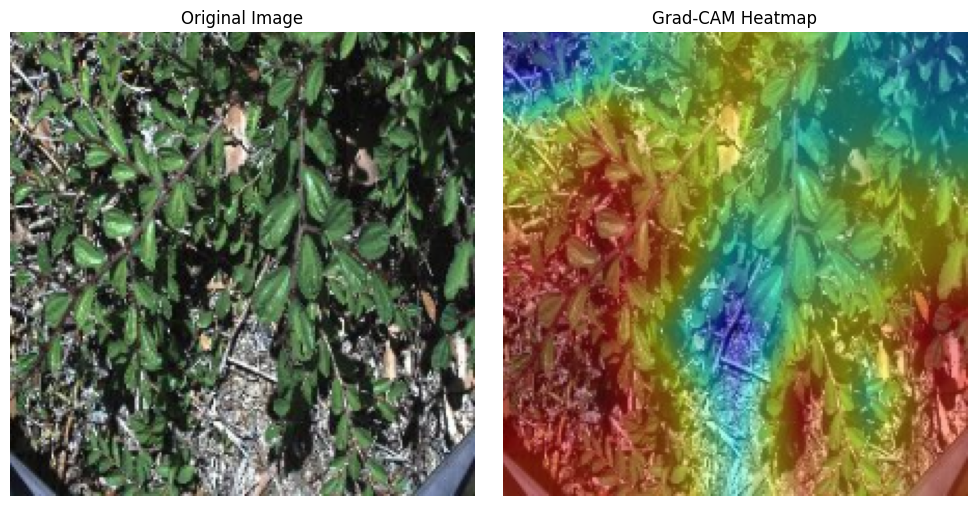

In [25]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

img_orig = cv2.imread(test_img_path)
img_orig = cv2.resize(img_orig, (224, 224))


heatmap = cv2.resize(heatmap, (img_orig.shape[1], img_orig.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)


superimposed_img = cv2.addWeighted(img_orig, 0.6, heatmap_color, 0.4, 0)


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Grad-CAM Heatmap")
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.tight_layout()
plt.show()


Predict Class

In [26]:
pred = model.predict(img_array)
predicted_class = class_labels[np.argmax(pred)]
print("🔍 Predicted Class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
🔍 Predicted Class: Chinee apple
